In [103]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

In [85]:
df= pd.read_csv(r"C:\Study Hub\notebooks\TrafficPrediction\merged_rieds_weather_100000.csv", index_col=0)
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,name,hour,date,temp,clouds,pressure,humidity,wind
0,1.49,Uber,2018-12-15 15:50:08.710,North End,Beacon Hill,26.0,1.0,Black SUV,15,2018-12-15,47.73,0.96,1022.45,0.860,4.06
1,1.28,Lyft,2018-12-14 23:10:15.587,North End,Financial District,7.0,1.0,Lyft,23,2018-12-14,42.41,0.88,1027.60,0.750,4.55
2,1.30,Uber,2018-12-02 03:28:01.882,Theatre District,South Station,27.5,1.0,Black SUV,3,2018-12-02,36.84,0.38,1022.89,0.810,0.30
3,2.28,Lyft,2018-11-30 01:57:59.147,Boston University,Beacon Hill,16.5,1.0,Lyft XL,1,2018-11-30,37.47,0.04,1012.02,0.660,7.94
4,1.27,Lyft,2018-11-27 15:18:22.350,Haymarket Square,Beacon Hill,11.0,1.0,Lyft XL,15,2018-11-27,40.98,1.00,989.33,0.875,10.77


In [86]:
df.drop('time_stamp', axis=1, inplace=True)

In [87]:
df.shape

(100000, 14)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          100000 non-null  float64
 1   cab_type          100000 non-null  object 
 2   destination       100000 non-null  object 
 3   source            100000 non-null  object 
 4   price             100000 non-null  float64
 5   surge_multiplier  100000 non-null  float64
 6   name              100000 non-null  object 
 7   hour              100000 non-null  int64  
 8   date              100000 non-null  object 
 9   temp              100000 non-null  float64
 10  clouds            100000 non-null  float64
 11  pressure          100000 non-null  float64
 12  humidity          100000 non-null  float64
 13  wind              100000 non-null  float64
dtypes: float64(8), int64(1), object(5)
memory usage: 11.4+ MB


In [89]:
df['date']= pd.to_datetime(df['date'])
df['month']= df['date'].dt.month
df['day']= df['date'].dt.day
df.drop('date', axis=1, inplace=True)

In [90]:
df.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,hour,temp,clouds,pressure,humidity,wind,month,day
0,1.49,Uber,North End,Beacon Hill,26.0,1.0,Black SUV,15,47.73,0.96,1022.45,0.860,4.06,12,15
1,1.28,Lyft,North End,Financial District,7.0,1.0,Lyft,23,42.41,0.88,1027.60,0.750,4.55,12,14
2,1.30,Uber,Theatre District,South Station,27.5,1.0,Black SUV,3,36.84,0.38,1022.89,0.810,0.30,12,2
3,2.28,Lyft,Boston University,Beacon Hill,16.5,1.0,Lyft XL,1,37.47,0.04,1012.02,0.660,7.94,11,30
4,1.27,Lyft,Haymarket Square,Beacon Hill,11.0,1.0,Lyft XL,15,40.98,1.00,989.33,0.875,10.77,11,27


In [91]:
X= df.drop(columns= 'price')
y= df['price']

### Build a preprocessing pipeline:

In [92]:
numeric_cols= X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols= X.select_dtypes(include= ['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols),
    ],
    remainder="drop"
)


In [93]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Baseline

In [94]:
pipe_lr= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['distance', 'surge_multiplier', 'hour', 'temp', 'clouds', 'pressure',
       'humidity', 'wind'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['cab_type', 'destination', 'source', 'name'], dtype='object'))])),
                ('regressor', LinearRegression())])

In [25]:
pred_lr = pipe_lr.predict(X_test)

## XGBOOST

In [27]:
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    tree_method="hist" 
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", xgb)
])

In [28]:
cv = GroupKFold(n_splits=5)

param_dist = {
    "model__n_estimators": [200, 300,400, 500],
    "model__learning_rate": [0.02,0.03, 0.05],
    "model__max_depth": [4, 5, 6, 7],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "model__min_child_weight": [1, 2, 3],
    "model__reg_alpha": [0, 0.1, 0.5],
    "model__reg_lambda": [1, 3, 5, 10],
}

In [29]:
rs_xgb = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=25,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [30]:
groups = X["source"].astype(str) + "_" + X["destination"].astype(str)

In [31]:
rs_xgb.fit(X, y, groups=groups)

print("Best MAE (CV):", -rs_xgb.best_score_)
print("Best params:", rs_xgb.best_params_)
best_xgb = rs_xgb.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best MAE (CV): 1.3623989275698318
Best params: {'model__subsample': 1.0, 'model__reg_lambda': 3, 'model__reg_alpha': 0.5, 'model__n_estimators': 200, 'model__min_child_weight': 3, 'model__max_depth': 7, 'model__learning_rate': 0.05, 'model__colsample_bytree': 1.0}


## Random Forest

In [34]:
rf= RandomForestRegressor(n_estimators=300, max_depth=7, random_state=42, n_jobs=-1)
model_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf)
])

In [37]:
# Cross-validation with GroupKFold
scores_rf = cross_val_score(
    model_rf,
    X, y,
    cv=cv,                 
    groups=groups,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

In [38]:
model_rf.fit(X, y)
print("RF CV MAE:", -scores_rf.mean())
best_rf = model_rf

RF CV MAE: 2.8913040913458197


### Feature Importance

<Axes: >

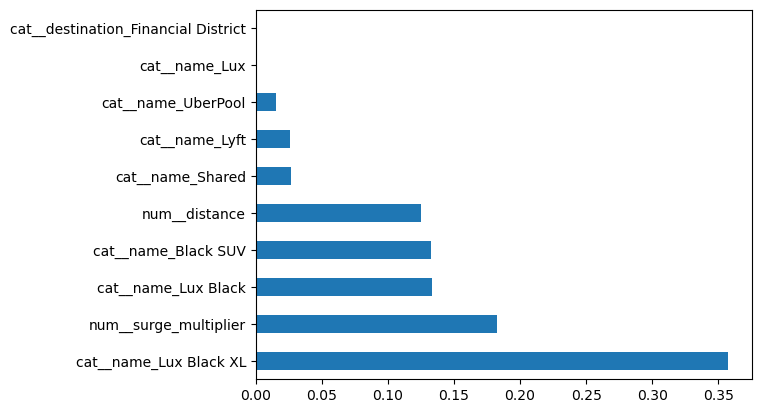

In [39]:
feat_names= model_rf.named_steps['preprocess'].get_feature_names_out()
importances= model_rf.named_steps['model'].feature_importances_
feat_importances= pd.Series(importances, index= feat_names)
feat_importances.nlargest(10).plot(kind='barh')

“Feature importance analysis using Random Forest shows that vehicle type and surge pricing are the dominant drivers of ride prices, followed by trip distance. Premium vehicle categories contribute disproportionately to higher fares, while destination-specific effects are relatively minor.”

# Gradient Boosting

In [40]:
grad = GradientBoostingRegressor(random_state=42)

In [41]:
grad_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", grad)])

In [42]:
param_dist = {
    "model__n_estimators": [200, 300, 400, 500],
    "model__learning_rate": [0.02, 0.03, 0.05, 0.1],
    "model__max_depth": [2, 3, 4, 5],        
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],  
    "model__max_features": [None, "sqrt", "log2"]
}

In [43]:
rs_gbr = RandomizedSearchCV(
    estimator=grad_model,
    param_distributions=param_dist,
    n_iter=25,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [44]:
rs_gbr.fit(X, y, groups=groups)

print("Best MAE (CV):", -rs_gbr.best_score_)
print("Best params:", rs_gbr.best_params_)
best_gbr = rs_gbr.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best MAE (CV): 1.3941206349679616
Best params: {'model__subsample': 0.9, 'model__n_estimators': 400, 'model__min_samples_split': 2, 'model__min_samples_leaf': 5, 'model__max_features': None, 'model__max_depth': 4, 'model__learning_rate': 0.05}


# Model Evaluation

In [46]:
result= []
for name, model in [("Linear Regression (Baseline)", pipe_lr),('XGBRegressor', best_xgb),('RandomForestRegressor', best_rf), ('GradientBoostingRegressor', best_gbr)]:
    model.fit(X_train, y_train)
    pred= model.predict(X_test)
    mae= mean_absolute_error(y_test, pred)
    rmse= np.sqrt(mean_squared_error(y_test, pred))
    result.append({'Model': name, 'MAE': mae, 'RMSE': rmse})
results_df= pd.DataFrame(result)
print(results_df)

                          Model       MAE      RMSE
0  Linear Regression (Baseline)  2.229082  3.227607
1                  XGBRegressor  1.199458  1.840178
2         RandomForestRegressor  2.804791  3.854000
3     GradientBoostingRegressor  1.283768  1.942085


# ANN

In [95]:
X_train_prep= preprocessor.fit_transform(X_train)
X_test_prep= preprocessor.transform(X_test)

In [98]:
X_train_nn = X_train_prep.toarray() if hasattr(X_train_prep, "toarray") else np.asarray(X_train_prep)
X_test_nn  = X_test_prep.toarray()  if hasattr(X_test_prep, "toarray")  else np.asarray(X_test_prep)

In [110]:
ann= Sequential([Input(shape= (42, )),
                Dense(128, activation='relu'),
                Dropout(0.3),
                Dense(64, activation='relu'),
                Dense(32, activation='relu'),
                Dense(1)
               ])

In [111]:
ann.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

In [112]:
checkpoint= ModelCheckpoint(filepath='best_model.keras', monitor='val_mae', save_best_only=True, mode='min', verbose=1)
early_stop= EarlyStopping(monitor='val_mae', patience=3, mode='min', restore_best_weights=True)

In [113]:
history= ann.fit(X_train_nn, y_train, epochs=100, batch_size=10, validation_split=0.2, callbacks=[early_stop, checkpoint])

Epoch 1/100
6371/6400 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 3.2952 - mae: 3.2952
Epoch 1: val_mae improved from None to 1.45247, saving model to best_model.keras
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 2.2071 - mae: 2.2071 - val_loss: 1.4525 - val_mae: 1.4525
Epoch 2/100
6366/6400 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 1.6483 - mae: 1.6483
Epoch 2: val_mae improved from 1.45247 to 1.35400, saving model to best_model.keras
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 10s 982us/step - loss: 1.6248 - mae: 1.6248 - val_loss: 1.3540 - val_mae: 1.3540
Epoch 3/100
6398/6400 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 1.5627 - mae: 1.5627
Epoch 3: val_mae improved from 1.35400 to 1.32743, saving model to best_model.keras
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 6s 963us/step - loss: 1.5458 - mae: 1.5458 - val_loss: 1.3274 - val_mae: 1.3274
Epoch 4/100
6393/6400 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5007 - mae: 1.5007
Epoch 4: val_mae did not improve from 1.32743
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 

In [114]:
pred_nn= ann.predict(X_test_nn)
mae_nn= mean_absolute_error(y_test, pred_nn)
print("Neural Network MAE:", mae_nn)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
Neural Network MAE: 1.237055639910698


In [115]:
ann.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,621 (186.02 KB)

 Trainable params: 15,873 (62.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,748 (124.02 KB)

# Final model comparison

In [119]:
result = []

for name, model in [
    ("Linear Regression (Baseline)", pipe_lr),
    ("XGBoost", best_xgb),
    ("Random Forest", best_rf),
    ("Gradient Boosting", best_gbr),
]:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))

    result.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse
    })

# ANN 
result.append({
    "Model": "Neural Network (ANN)",
    "MAE": mae_nn,   
})

results_df = pd.DataFrame(result)


In [120]:
print(results_df)

                          Model       MAE      RMSE
0  Linear Regression (Baseline)  2.229082  3.227607
1                       XGBoost  1.199458  1.840178
2                 Random Forest  2.804791  3.854000
3             Gradient Boosting  1.283768  1.942085
4          Neural Network (ANN)  1.237056       NaN


“A comprehensive evaluation was conducted using a consistent test set and MAE/RMSE metrics. Linear regression served as a baseline and confirmed non-linear pricing dynamics. Among all models, XGBoost achieved the best performance (Test MAE = 1.20), demonstrating superior generalization on structured ride pricing data. A neural network also achieved competitive results (Test MAE = 1.24), while gradient boosting showed strong but slightly inferior performance. Random Forest underperformed in this setting. Based on accuracy, stability, and interpretability, XGBoost was selected as the final deployment model.”

# Save Best Model

In [121]:
import joblib

joblib.dump(best_xgb, "best_xgb.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")

['preprocessor.pkl']